# Project Luther - Predicting Movie Lifetime Gross

# Table of contents
1. [Introduction](#introduction)
2. [Webscrape Movie Reviews From IMBD](#Webscrape Movie Reviews From IMBD)
3. [Merging IMBD and BoxOfficeMojo Data](#Merging IMBD and BoxOfficeMojo Data)
4. [Predictive Models](#Predictive Models)
4. [Simple Test Case](#Simple Test Case)

## Introduction <a name="introduction"></a>

This project webscrapes IMDB movie rankings using python’s BeautifulSoup package, and merges this data with BoxOfficeMojo information (www.boxofficemojo.com) related to movie boxoffice grosses. Then linear regression, decision tree, and random forest models are run with Scikit Learn Regression producing the highest R^2 of 82% that shows IMDB rankings and votes as important factors in predicting movie gross. Finally, a simple test case predicts what a fictional movie with a certain rating, opening, and vote number would make in lifetime gross at the boxoffice. 

## Webscrape Movie Reviews From IMBD <a name="Webscrape Movie Reviews From IMBD"></a>

In [86]:
# Webscraping/importing/system
from bs4 import BeautifulSoup
import requests
import pandas as pd
import os
import json
import pickle
# Graphing
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import plt
# Modeling
import statsmodels.formula.api as smf
import patsy
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_imdb_data():

#Sample website below:
#http://www.imdb.com/search/title?count=250&countries=us&languages=en&release_date
#=1972-01-01,2014-12-31&title_type=feature&view=simple&start=1
    
    base_url = "http://www.imdb.com/search/title"
    params = {
        "count": 250,
        "countries": "us",
        "languages": "en",
        "release_date": "1972-01-01,2014-12-31",
        "title_type": "feature",
        "view":"simple",
        "start": 1
    }
    data = []
    # Loop to navigate through pages by changing the start parameter
    while True:
        # Get content from IMDB
        content = requests.get(base_url, params=params).content
        params["start"] += 250
        
        soup = BeautifulSoup(content)
        
        # If no data is found, end the while loop
        if not soup.find("tr", class_=["even", "odd"]) or params["start"] > 10000:
            break
        
        # For each row (data), get title, ratings. Rows are tagged with even and odd class
        # tr = table row, td = table detail
        for tr in soup.find_all("tr", class_=["even", "odd"]):
            title_tag = tr.find("td", class_="title") # find td that has class = title
            title = title_tag.find("a").text # whatever is between is what I want
            
            # Get the Year. Strip the first and last value that contain the paranteses
            year = title_tag.find("span", class_="year_type").text[1:-1]
            
            # Get all td tags to get to rating and votes that don't have any class to them
            # No class names on rating
            td_tags = tr.find_all("td")
            # Get ratings.  If they don't exist, make empty string
            rating_tag = td_tags[2].find("b")
            if rating_tag:
                rating = rating_tag.text
            else:
                rating = ""
            # Get votes and remove the thousands seperator to get number
            votes = td_tags[3].text.strip().replace(",", "")
            # Append the results to data
            data.append({
                    "title": title,
                    "year": year,
                    "rating": rating,
                    "votes": votes
                })
    return data

In [3]:
data = get_imdb_data()

In [4]:
# Transform data to a dataframe, save as a pickle file

In [5]:
# pd.DataFrame(data)
# imdb = pd.DataFrame(data)
# with open('imdb1970.pkl', 'w') as picklefile:
#    pickle. dump(imdb, picklefile) 

In [6]:
imdbfile = 'imdb1970.pkl'
assert os.path.isfile(imdbfile),'Oops, move your json or change the metafile path'
imdb_df = pd.DataFrame(pd.read_pickle(imdbfile))
imdb_df = imdb_df # same as mojo_df.transpose()
imdb_df.head()

,rating,title,votes,year
0,9.2,The Godfather,1097794,1972
1,7.4,Labyrinth,90636,1986
2,8.6,Interstellar,832622,2014
3,7.8,Kingsman: The Secret Service,351702,2014
4,8.2,The Wolf of Wall Street,709910,2013


In [7]:
print imdb_df.shape
print imdb_df.columns.values

(9750, 4)
['rating' 'title' 'votes' 'year']


## Merging IMBD and BoxOfficeMojo Data <a name="Merging IMBD and BoxOfficeMojo Data"></a>

### BoxOfficeMojo Data

In [10]:
mojofile = 'mojo_movies.pkl'

In [11]:
assert os.path.isfile(mojofile), 'Oops, move your pickle or change the mojofile path'

In [12]:
mojo_df = pd.DataFrame(pd.read_pickle(mojofile))
mojo_df = mojo_df.T # same as mojo_df.transpose()
mojo_df.head(2)

,date,genres,lifetime gross,lifetime gross theaters,mojo_url,opening,opening theaters,rank,studio,title,year
/movies/?id=,2015-07-31 00:00:00,"[Biopic - Music, Foreign Language]",8808,5,/movies/?id=,5295,5,44,MBox,Paul Coelho's Best Story,2015
/movies/?id=10000bc.htm,2008-03-07 00:00:00,[Adventure - Period],94784201,3454,/movies/?id=10000bc.htm,35867488,3410,20,WB,"10,000 B.C.",2008


### 2. Check for Abnormalities

In [13]:
# Incorrect Dates

In [14]:
mojo_df.year.unique()

array([2015, 2008, 2013, 2014, 1982, 1996, 2000, 2007, 1999, 2009, 2011,
       2004, 2006, 1992, 2005, 1986, 2012, 1997, 1988, 1984, 1995, 1998,
       1968, 2010, 1990, 1991, 2002, 1993, 2003, 1989, 2001, 1994, 2016,
       1987, 1980, 1981, nan, 1985, 2036, 1979, 2030, 1976, 1983, 1973,
       1978, 1975, 1974, 1977, 2051, 2038, 2045, 1972, 2021, 2049, 2042,
       2046, 2062, 2039, 2060, 2047, 2057, 1970, 2035, 2041, 2064, 2054], dtype=object)

In [15]:
# turns out crazy date movies are 100 years off & full of nan's.
crazy_dates = mojo_df[mojo_df.year > 2016]
print len(crazy_dates)
crazy_dates.head(2)

20


,date,genres,lifetime gross,lifetime gross theaters,mojo_url,opening,opening theaters,rank,studio,title,year
/movies/?id=afterthethinman.htm,2036-12-25 00:00:00,[Comedy - Sequel (Live Action)],n/a,-,/movies/?id=afterthethinman.htm,n/a,-,-,MGM,After the Thin Man,2036
/movies/?id=allquietonthewesternfront.htm,2030-04-21 00:00:00,[War - World War I],n/a,-,/movies/?id=allquietonthewesternfront.htm,n/a,-,-,Uni.,All Quiet on the Western Front,2030


In [16]:
mjdf = mojo_df.copy()
mjdf = mjdf[mjdf.year < 2017]

In [17]:
# Get important columns and change to more user friendly column names

In [18]:
col_names = [col.replace(' ','_') for col in mjdf.columns]
wanted = [2,3,5,6,9,10]
col_names = [col for i,col in enumerate(col_names) if i in wanted]
col_names_old = [col.replace('_',' ') for col in col_names]
mjdf = pd.DataFrame(mjdf[col_names_old].values,columns=col_names)
mjdf.head()

,lifetime_gross,lifetime_gross_theaters,opening,opening_theaters,title,year
0,8808,5,5295,5,Paul Coelho's Best Story,2015
1,94784201,3454,35867488,3410,"10,000 B.C.",2008
2,60522097,3401,27520040,3401,After Earth,2013
3,53895,24,24120,24,"1,000 Times Good Night",2014
4,78350,33,78350,33,Bugs Bunny's 1001 Rabbit Tales,1982


In [19]:
# 'n/a' in columns make each column an object type: Fix

In [20]:
mjdf.dtypes # Everything is an object

lifetime_gross             object
lifetime_gross_theaters    object
opening                    object
opening_theaters           object
title                      object
year                       object
dtype: object

In [21]:
mjdf = mjdf.replace('n/a',np.nan)
mjdf.dtypes

lifetime_gross             float64
lifetime_gross_theaters     object
opening                    float64
opening_theaters            object
title                       object
year                         int64
dtype: object

In [22]:
# Drop Nans in Lifetime_gross column

In [23]:
mjdf = mjdf.dropna(subset=['lifetime_gross'])

In [24]:
# Plot lifetime gross over the years

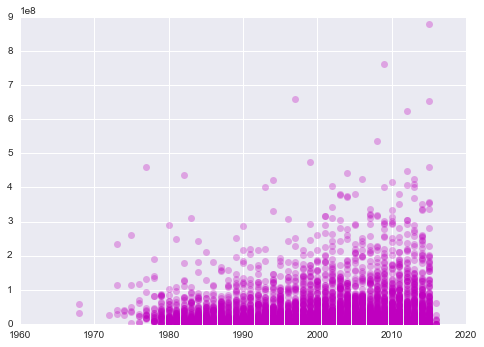

In [25]:
plt.plot(mjdf['year'],mjdf['lifetime_gross'],'mo',alpha=0.3);

In [26]:
# Plot movies per year

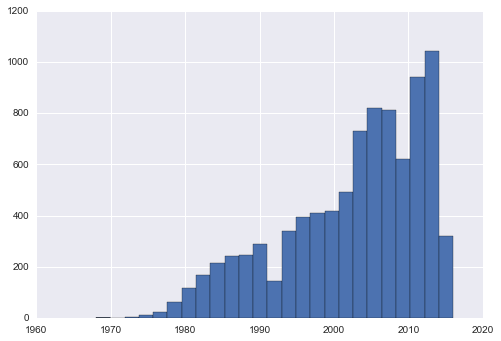

In [27]:
mjdf.year.hist(bins=25);

#### Clean and Merge with IMBD Data

In [28]:
merged_on_raw_title = pd.merge(mjdf,imdb_df,on='title')
merged_on_raw_title.head(2)

,lifetime_gross,lifetime_gross_theaters,opening,opening_theaters,title,year_x,rating,votes,year_y
0,60522097.0,3401,27520040.0,3401,After Earth,2013,4.9,152912,2013
1,54240821.0,2167,10979290.0,2023,The Hundred-Foot Journey,2014,7.3,48007,2014


In [29]:
# Function to create uniform title names

In [30]:
def lightly_process_title(title):
    title = title.replace(' ','').lower()
    charlist = list(title)
    charlist = [char for char in charlist if char.isalnum()]
    return ''.join(charlist)

In [31]:
t = "102 Dalmatians: A Puppy Comes-of-Age"
lightly_process_title(t)

'102dalmatiansapuppycomesofage'

In [32]:
imdb_df.loc[:,'title2'] = imdb_df.loc[:,'title'].apply(lightly_process_title)
mjdf['title2'] = mjdf['title'].apply(lightly_process_title)
merged_on_lighty_processed_title = pd.merge(mjdf,imdb_df,on='title2',how='inner')

In [33]:
merged_on_lighty_processed_title.head(2)

,lifetime_gross,lifetime_gross_theaters,opening,opening_theaters,title_x,year_x,title2,rating,title_y,votes,year_y
0,94784201.0,3454,35867488.0,3410,"10,000 B.C.",2008,10000bc,5.1,"10,000 BC",105847,2008
1,60522097.0,3401,27520040.0,3401,After Earth,2013,afterearth,4.9,After Earth,152912,2013


In [34]:
# Filter for relevant columns to model
combined = merged_on_lighty_processed_title
combined.columns
imdb_num = combined[['rating','votes','lifetime_gross','year_y','lifetime_gross_theaters','opening','opening_theaters']]

In [35]:
imdb_num.head(2)

,rating,votes,lifetime_gross,year_y,lifetime_gross_theaters,opening,opening_theaters
0,5.1,105847,94784201.0,2008,3454,35867488.0,3410
1,4.9,152912,60522097.0,2013,3401,27520040.0,3401


In [36]:
imdb_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4134 entries, 0 to 4133
Data columns (total 7 columns):
rating                     4134 non-null object
votes                      4134 non-null object
lifetime_gross             4134 non-null float64
year_y                     4134 non-null object
lifetime_gross_theaters    4134 non-null object
opening                    4002 non-null float64
opening_theaters           4134 non-null object
dtypes: float64(2), object(5)
memory usage: 258.4+ KB


In [37]:
# Get rid of rows with '-'

In [38]:
imdb_copy = imdb_num
imdb_copy[imdb_copy.lifetime_gross_theaters == '-']
imdb_copy = imdb_copy[imdb_copy.lifetime_gross_theaters != '-']
imdb_copy = imdb_copy[imdb_copy.opening_theaters != '-']
imdb_copy[imdb_copy.opening_theaters == '-']
imdb_copy.head(2)

,rating,votes,lifetime_gross,year_y,lifetime_gross_theaters,opening,opening_theaters
0,5.1,105847,94784201.0,2008,3454,35867488.0,3410
1,4.9,152912,60522097.0,2013,3401,27520040.0,3401


In [39]:
# print imdb_copy.isnull() # boolean true/fales
# print imdb_copy.isnull().any(axis=1) # single col of true/falses depending on any nulls in rows
# print imdb_copy.isnull().any(axis=1).nonzero() # return rows that are non zero or 1 for true
# print imdb_copy.isnull().any(axis=1).nonzero()[0] # take first element of array
print imdb_copy.opening.shape
print imdb_copy.isnull().any(axis=1).nonzero()[0]

(3961,)
[ 354  567 1045]


In [40]:
# check a row with Nan
imdb_copy.iloc[567,:]

rating                             6.5
votes                             2940
lifetime_gross             2.16712e+07
year_y                            1979
lifetime_gross_theaters            934
opening                            NaN
opening_theaters                   934
Name: 589, dtype: object

In [41]:
# drop Nans, create final df
imdb_copy.dropna().info()
imdb_final = imdb_copy.dropna()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3958 entries, 0 to 4132
Data columns (total 7 columns):
rating                     3958 non-null object
votes                      3958 non-null object
lifetime_gross             3958 non-null float64
year_y                     3958 non-null object
lifetime_gross_theaters    3958 non-null object
opening                    3958 non-null float64
opening_theaters           3958 non-null object
dtypes: float64(2), object(5)
memory usage: 247.4+ KB


In [42]:
# Change dtypes
imdb_final['rating'] = imdb_final['rating'].map(lambda x: float(x))
imdb_final['votes'] = imdb_final['votes'].map(lambda x: int(x))
imdb_final['lifetime_gross'] = imdb_final['lifetime_gross'].map(lambda x: int(x))
imdb_final['year_y'] = imdb_final['year_y'].map(lambda x: int(x))
imdb_final['lifetime_gross_theaters'] = imdb_final['lifetime_gross_theaters'].map(lambda x: int(x))
#imdb_final['opening'] = imdb_final['opening'].map(lambda x: float(x))
imdb_final['opening_theaters'] = imdb_final['opening_theaters'].map(lambda x: int(x))

In [43]:
imdb_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3958 entries, 0 to 4132
Data columns (total 7 columns):
rating                     3958 non-null float64
votes                      3958 non-null int64
lifetime_gross             3958 non-null int64
year_y                     3958 non-null int64
lifetime_gross_theaters    3958 non-null int64
opening                    3958 non-null float64
opening_theaters           3958 non-null int64
dtypes: float64(2), int64(5)
memory usage: 247.4 KB


## Predictive Models <a name="Predictive Models"></a>

### Regression - Scikit Learn - 82% R^2

In [44]:
features = ['votes', 'rating','year_y','lifetime_gross_theaters','opening','opening_theaters']
response = ['lifetime_gross']

In [45]:
# Create an empty model
lin_reg = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
X = imdb_final[features]
# Choose the response variable(s)
y = imdb_final[response]
# Fit the model to the full dataset. Unlike statsmodel, have to give it the data
lin_reg_results = lin_reg.fit(X, y)
# Print out the R^2 for the model against the full dataset
lin_reg.score(X,y)

0.82035661907034696

### Regression - Scikit Learn - Add Predictions

In [46]:
predictions = lin_reg.predict(X)
len(predictions) # 3958
imdb_final['predictions'] = predictions
imdb_final['predictions'] = imdb_final['predictions'].astype(int)

In [47]:
imdb_final.head(2)

,rating,votes,lifetime_gross,year_y,lifetime_gross_theaters,opening,opening_theaters,predictions
0,5.1,105847,94784201,2008,3454,35867488.0,3410,110629600
1,4.9,152912,60522097,2013,3401,27520040.0,3401,88329400


In [48]:
# Scikit Learn Predictions/Fit Plots shows predictions being relatively accurate 

(-100000000.0, 800000000.0, -100000000.0, 700000000.0)

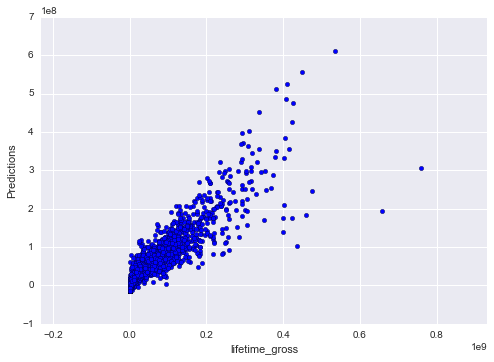

In [49]:
# Plot Predictions vs Fit
fig, ax = plt.subplots(1, 1)
ax.scatter(imdb_final['lifetime_gross'],imdb_final['predictions'])
ax.set_xlabel('lifetime_gross')
ax.set_ylabel('Predictions')
ax.axis('equal')

In [50]:
lin_reg.intercept_

array([  1.53537107e+09])

In [51]:
lin_reg.coef_

array([[  1.17140002e+02,   2.87180528e+05,  -7.70529500e+05,
          3.82807715e+04,   2.65810051e+00,  -3.48806297e+04]])

In [52]:
imdb_final[['lifetime_gross','predictions']].head(2)

,lifetime_gross,predictions
0,94784201,110629600
1,60522097,88329400


In [53]:
# R Squared - Same as above 
metrics.r2_score(imdb_final['lifetime_gross'], imdb_final['predictions'])

0.82035661963692108

In [54]:
# MSE
np.sqrt(metrics.mean_squared_error(imdb_final['lifetime_gross'], imdb_final['predictions']))

26544927.386294644

In [55]:
# MAE - Scikit Learn
metrics.mean_absolute_error(imdb_final['lifetime_gross'], imdb_final['predictions'])

14053009.380242547

### Regression - StatsModels - Residual Plots

In [56]:
# Define the model 
model = smf.ols('lifetime_gross ~ votes + rating + year_y + lifetime_gross_theaters + opening + opening_theaters', data=imdb_final)
# Fit the model
fit = model.fit()
# Check out the results
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lifetime_gross   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     3007.
Date:                Sun, 25 Dec 2016   Prob (F-statistic):               0.00
Time:                        13:35:43   Log-Likelihood:                -73276.
No. Observations:                3958   AIC:                         1.466e+05
Df Residuals:                    3951   BIC:                         1.466e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                1.535e+09   9.38e+07     16.365      0.000      1.35e+09  1.72e+09
votes                     117.1400      4.963     23.601      0.000       107.409   126.871
rating                   2.872e+05   4.89e+05      0.587      0.557     -6.72e+05  1.25e+06
year_y                  -7.705e+05   4.68e+04    -16.457      0.000     -8.62e+05 -6.79e+05
lifetime_gross_theaters  3.828e+04   1227.532     31.185      0.000      3.59e+04  4.07e+04
opening                     2.6581      0.041     64.741      0.000         2.578     2.739
opening_theaters        -3.488e+04   1199.447    -29.081      0.000     -3.72e+04 -3.25e+04
==============================================================================
Omnibus:                     4239.514   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           730617.881
Skew:                           5.032   Prob(JB):                         0.00
Kurtosis:                      68.795   Cond. No.                     4.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

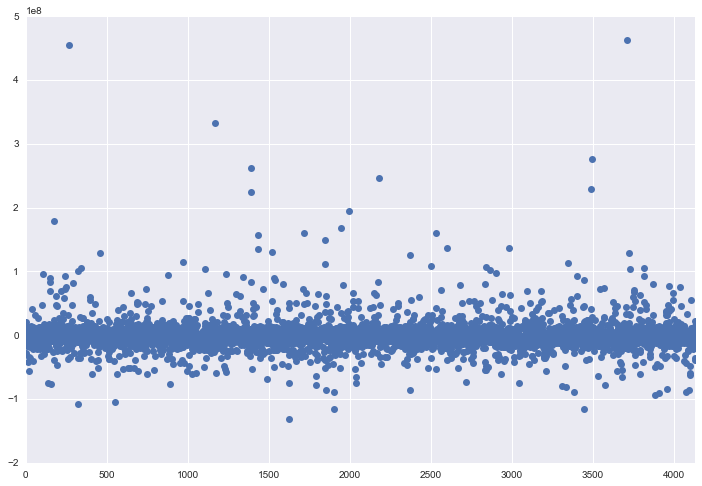

In [57]:
# Use statsmodels to plot the residuals
# Accurate because most dots around zero
fit.resid.plot(style='o', figsize=(12,8))

### Regression - StatsModels - Array Method
#### Shows importance of features based on p-values - votes most important feature

In [58]:
X2=X

In [59]:
X2["Index"] = 1
X2.head(2)

,votes,rating,year_y,lifetime_gross_theaters,opening,opening_theaters,Index
0,105847,5.1,2008,3454,35867488.0,3410,1
1,152912,4.9,2013,3401,27520040.0,3401,1


In [60]:
lm = smf.OLS(np.array(y), np.array(X2))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     3007.
Date:                Sun, 25 Dec 2016   Prob (F-statistic):               0.00
Time:                        13:35:44   Log-Likelihood:                -73276.
No. Observations:                3958   AIC:                         1.466e+05
Df Residuals:                    3951   BIC:                         1.466e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1           117.1400      4.963     23.601      0.000       107.409   126.871
x2          2.872e+05   4.89e+05      0.587      0.557     -6.72e+05  1.25e+06
x3         -7.705e+05   4.68e+04    -16.457      0.000     -8.62e+05 -6.79e+05
x4          3.828e+04   1227.532     31.185      0.000      3.59e+04  4.07e+04
x5             2.6581      0.041     64.741      0.000         2.578     2.739
x6         -3.488e+04   1199.447    -29.081      0.000     -3.72e+04 -3.25e+04
const       1.535e+09   9.38e+07     16.365      0.000      1.35e+09  1.72e+09
==============================================================================
Omnibus:                     4239.514   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           730617.881
Skew:                           5.032   Prob(JB):                         0.00
Kurtosis:                      68.795   Cond. No.                     4.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
results.params

array([  1.17140002e+02,   2.87180528e+05,  -7.70529500e+05,
         3.82807715e+04,   2.65810051e+00,  -3.48806297e+04,
         1.53537107e+09])

In [62]:
results.rsquared

0.82035661907034696

In [63]:
# confidence intervals of coefficients
results.conf_int()

array([[  1.07409084e+02,   1.26870920e+02],
       [ -6.71892812e+05,   1.24625387e+06],
       [ -8.62326039e+05,  -6.78732960e+05],
       [  3.58741160e+04,   4.06874271e+04],
       [  2.57760527e+00,   2.73859575e+00],
       [ -3.72322238e+04,  -3.25290356e+04],
       [  1.35143486e+09,   1.71930728e+09]])

In [64]:
zip(features, lin_reg.coef_)

[('votes', array([  1.17140002e+02,   2.87180528e+05,  -7.70529500e+05,
           3.82807715e+04,   2.65810051e+00,  -3.48806297e+04]))]

In [65]:
# Sorted P-Values
sorted_pvalues = sorted(results.pvalues)
pvalues_results = sorted_pvalues[1:]
pvalues_results

[4.5756071994848993e-191,
 1.1916560733941833e-168,
 2.5347520966892195e-115,
 6.5687256434470513e-59,
 2.6859462146171326e-58,
 0.55719528799805107]

In [66]:
#Sort by best pvalue features dataFrame
p = pd.DataFrame({'p_value':pvalues_results, 'feature':features})
p

,feature,p_value
0,votes,4.575607e-191
1,rating,1.191656e-168
2,year_y,2.534752e-115
3,lifetime_gross_theaters,6.568726e-59
4,opening,2.685946e-58
5,opening_theaters,5.571953e-01


In [67]:
relevant_features = list(p[p.p_value < .05]['feature'])
relevant_features

['votes', 'rating', 'year_y', 'lifetime_gross_theaters', 'opening']

### Decision Trees

#### Decision Tree Model gives lower r^2 of 60.5% and depicts different feature importance set

In [68]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

In [69]:
# Create a decision tree classifier instance (start out with a small tree for interpretability)
ctree = tree.DecisionTreeRegressor(random_state=1)

In [70]:
# Fit the decision tree classifier
ctree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [71]:
# Create a feature vector
features2 = X_train.columns.tolist()

In [72]:
features2

['votes',
 'rating',
 'year_y',
 u'lifetime_gross_theaters',
 u'opening',
 u'opening_theaters',
 'Index']

In [73]:
# predictions_tree
predictions_tree = ctree.predict(X_test)

In [74]:
# R Squared - Scikit Learn
metrics.r2_score(y_test, predictions_tree)

0.60524228246263756

In [75]:
# MAE
metrics.mean_absolute_error(y_test, predictions_tree)

15726128.252525253

In [76]:
# MSE
np.sqrt(metrics.mean_squared_error(y_test, predictions_tree))

39574427.315987639

In [77]:
# Which features are the most important?
# Clean up the output. # will add up to 1. Think %
pd.DataFrame(zip(list(X.columns), ctree.feature_importances_)).sort_values(by=1, ascending=False)

,0,1
4,opening,0.741698
0,votes,0.067361
1,rating,0.061283
5,opening_theaters,0.054925
3,lifetime_gross_theaters,0.048228
2,year_y,0.026506
6,Index,0.000000


### Random Forest

#### Random Forrest Model gives slightly lower r^2 of 78.7% and depicts different feature importance set

In [78]:
rfclf = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfclf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [79]:
predictions_tree = rfclf.predict(X_test)

In [80]:
# R2
metrics.r2_score(y_test, predictions_tree)

0.78742068688284461

In [81]:
# MEA
metrics.mean_absolute_error(y_test, predictions_tree)

12202244.542131314

In [82]:
# MSE
np.sqrt(metrics.mean_squared_error(y_test, predictions_tree))

29040883.457348064

In [83]:
# compute the feature importances
rf_feature_imp = pd.DataFrame(zip(list(X.columns), rfclf.feature_importances_)).sort_index(by=1, ascending=False)
rf_feature_imp

,0,1
4,opening,0.747734
0,votes,0.083793
3,lifetime_gross_theaters,0.051705
5,opening_theaters,0.042593
1,rating,0.041977
2,year_y,0.032198
6,Index,0.000000


## Simple Test Case <a name="Simple Test Case"></a>

#### Simple test case of a 9 star rating with a 10,000,000 and 150,000 is predicted to make about $120 million in lifetime gross

In [84]:
X_sub_features = imdb_final[['rating', 'opening', 'votes']]

X_train, X_test, y_train, y_test = train_test_split(X_sub_features,y, random_state=1)
rfclf = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfclf.fit(X_train, y_train)

predictions_tree = rfclf.predict(X_test)
metrics.r2_score(y_test, predictions_tree)

# To Predict a Movie Revenue
rfclf.predict([9, 10000000, 150000])[0]

120888161.83

In [85]:
rfclf.feature_importances_

array([ 0.07129083,  0.79537188,  0.13333729])